# **Description of the project**

The aim is to assess tweets on airlines companies and to assess whether I can extract consumer satisfaction for each airline based on the Tweets. In line with this objective, I would like to compare the achivement of very naive NLP methods such as the AFINN method to more advanced methods such as BERT. Then, I compare the performance of both methods and to analyse whether both methods provide the same results. Finally, I would like to see if it could be interesting to combine both methods by asssigning weights to the score assigned by both methods to see if a hybrid method could help achieving better results. 

The dataset was found in kaggle : https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [4]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


In [5]:
! pip install afinn

     |████████████████████████████████| 52 kB 1.1 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=2e37cfdad970865074f120a69f284ba68ffc90b8021d8f22f0b10c9ffb39c967
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import re

from pandas_profiling import ProfileReport

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer

import nltk
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams

import keras

# vectorisor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import io

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# Please select file "Tweets.csv" from Kaggle link at first line
# OR drag and drop the file.
from google.colab import files
uploaded = files.upload()


Saving Tweets.csv to Tweets (1).csv


In [9]:
df = pd.read_csv(io.BytesIO(uploaded['Tweets.csv']))

In [ ]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)



# **Descriptive statistics**

In [ ]:
#Number of tweets in the database :
length = len(df['text'])
print("Number of tweets in the database :", length)

Number of tweets in the database : 14640


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

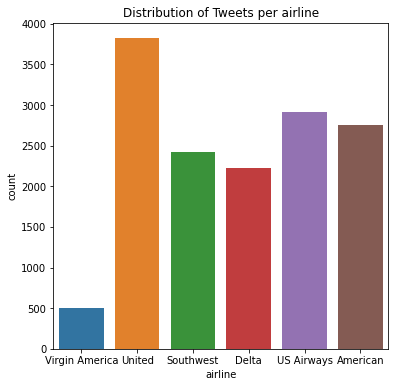

In [ ]:
fig = plt.figure(figsize=(6, 6))
sns.countplot(x = 'airline', data = df)
plt.title('Distribution of Tweets per airline')
fig.savefig('airline_tweets.png')

files.download('airline_tweets.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

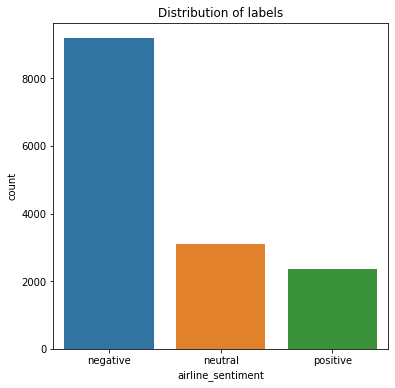

In [ ]:
label_order = ['negative', 'neutral', 'positive']
fig = plt.figure(figsize=(6, 6))
sns.countplot(x = 'airline_sentiment', data = df, order = label_order)
plt.title('Distribution of labels')
fig.savefig('label_distrib.png')

files.download('label_distrib.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

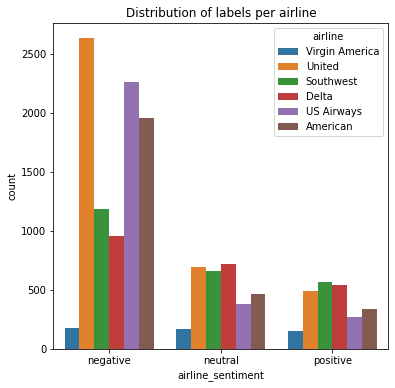

In [ ]:

fig = plt.figure(figsize=(6, 6))
sns.countplot(x = 'airline_sentiment', data = df, hue = 'airline', order = label_order)
plt.title('Distribution of labels per airline')
fig.savefig('label_distrib_airline.png')

files.download('label_distrib_airline.png')

In [ ]:
profile = ProfileReport(df, title="Airline Dataset", html={"style": {"full_width": True}})

In [ ]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#Simple descriptive statistics 
df['text_len'] = df["text"].apply(lambda s: len(s.split()))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

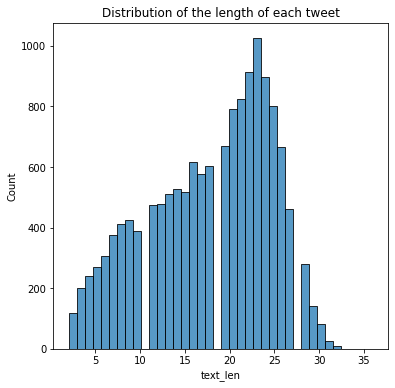

In [ ]:

fig = plt.figure(figsize=(6, 6))
sns.histplot(data=df, x="text_len")
plt.title('Distribution of the length of each tweet')
fig.savefig('tweet_length.png')

files.download('tweet_length.png')


In [ ]:
import string
def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)
 
def remove_at(tokens):
  tokens = map(lambda x: x.strip("@* "), tokens)
  return list(tokens)

def remove_punkt2(tokens):
  tokens = map(lambda x: x.replace('...', ''), tokens)
  return list(tokens)  

#We addthis function in addition to the tokenization of nltk without punctuation, otherwise symbols such as "?" remain as tokens
def remove_punkt(tokens):
  tokens = list(filter(lambda token: token not in string.punctuation, tokens))
  return list(tokens)

In [ ]:
from tqdm import tqdm

def tokenize_url_hashtags(corpus, tweets=False):
  if tweets:
    tokenizer = TweetTokenizer()
  else:
    tokenizer = TreebankWordTokenizer()  
    # Life hack : treebank word tokenizer won't keep html code in one token.
    # To preprocess economics news corpus, use tweettokenizer. 
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      tokens = remove_url(tokens)
      tokens = remove_html(tokens)
      tokens = remove_hashtags(tokens)
      tokens = remove_at(tokens)
      tokens = remove_punkt(tokens)
      tokens = remove_punkt2(tokens)
      tokens = list(map(lambda x: x.lower(), tokens))
      tokenized_sentences.append(tokens)
  return tokenized_sentences

In [ ]:
cleaned_df = tokenize_url_hashtags(df.text.array, tweets=True)

100%|██████████| 14640/14640 [00:03<00:00, 4552.42it/s]


In [ ]:
len(cleaned_df)

29333

In [ ]:
flat_tokens = [item for sublist in cleaned_df for item in sublist]

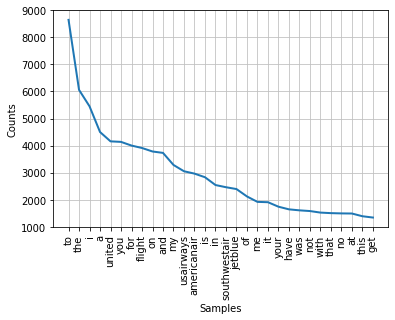

In [ ]:
fd = nltk.FreqDist(flat_tokens)
fd.plot(30,cumulative=False)

In [ ]:
tokens_without_sw = [word for word in flat_tokens if not word in stopwords.words()]

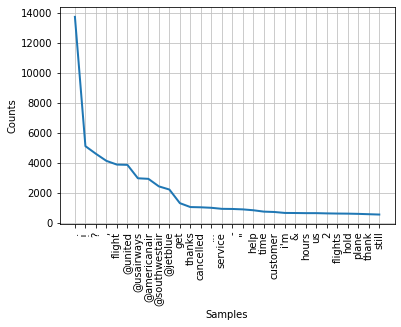

In [ ]:
tokens_without_sw.remove('')
fd = nltk.FreqDist(tokens_without_sw)
fd.plot(30,cumulative=False)


Most frequent words

In [ ]:
from collections import Counter
Counter = Counter(flat_tokens)
most_occur = Counter.most_common(20)
print(most_occur)
out = pd.DataFrame.from_records(list(dict(most_occur).items()), columns=['words','count'])
print(out.to_latex())

[('to', 8648), ('the', 6060), ('i', 5452), ('a', 4501), ('united', 4157), ('you', 4137), ('for', 4001), ('flight', 3911), ('on', 3782), ('and', 3730), ('my', 3284), ('usairways', 3051), ('americanair', 2964), ('is', 2830), ('in', 2542), ('southwestair', 2461), ('jetblue', 2393), ('of', 2120), ('me', 1919), ('it', 1907)]
\begin{tabular}{llr}
\toprule
{} &         words &  count \\
\midrule
0  &            to &   8648 \\
1  &           the &   6060 \\
2  &             i &   5452 \\
3  &             a &   4501 \\
4  &        united &   4157 \\
5  &           you &   4137 \\
6  &           for &   4001 \\
7  &        flight &   3911 \\
8  &            on &   3782 \\
9  &           and &   3730 \\
10 &            my &   3284 \\
11 &     usairways &   3051 \\
12 &   americanair &   2964 \\
13 &            is &   2830 \\
14 &            in &   2542 \\
15 &  southwestair &   2461 \\
16 &       jetblue &   2393 \\
17 &            of &   2120 \\
18 &            me &   1919 \\
19 &            it 

Bigrams



In [ ]:
df['bigrams'] = df['text'].apply(lambda row: list(nltk.bigrams(row.split(' '))))

In [ ]:
df['bigrams']

0        [(@VirginAmerica, What), (What, @dhepburn), (@...
1        [(@VirginAmerica, plus), (plus, you've), (you'...
2        [(@VirginAmerica, I), (I, didn't), (didn't, to...
3        [(@VirginAmerica, it's), (it's, really), (real...
4        [(@VirginAmerica, and), (and, it's), (it's, a)...
                               ...                        
14635    [(@AmericanAir, thank), (thank, you), (you, we...
14636    [(@AmericanAir, leaving), (leaving, over), (ov...
14637    [(@AmericanAir, Please), (Please, bring), (bri...
14638    [(@AmericanAir, you), (you, have), (have, my),...
14639    [(@AmericanAir, we), (we, have), (have, 8), (8...
Name: bigrams, Length: 14640, dtype: object

In [ ]:
import itertools
bigrams = list(itertools.chain(*df['bigrams']))

# Create counter of words in clean bigrams
bigram_counts = Counter(bigrams)

d = bigram_counts.most_common(20)

In [ ]:
out = pd.DataFrame.from_records(list(dict(d).items()), columns=['bigrams','count'])


In [ ]:
print(out.to_latex())

\begin{tabular}{llr}
\toprule
{} &                 bigrams &  count \\
\midrule
0  &               (on, the) &    533 \\
1  &               (to, get) &    477 \\
2  &              (for, the) &    446 \\
3  &               (I, have) &    435 \\
4  &              (on, hold) &    400 \\
5  &     (customer, service) &    358 \\
6  &                (to, be) &    357 \\
7  &            (my, flight) &    355 \\
8  &               (in, the) &    355 \\
9  &  (Cancelled, Flightled) &    350 \\
10 &                (for, a) &    342 \\
11 &               (to, the) &    323 \\
12 &                (I, was) &    302 \\
13 &            (@united, I) &    296 \\
14 &            (trying, to) &    272 \\
15 &             (a, flight) &    259 \\
16 &               (out, of) &    256 \\
17 &             (hold, for) &    242 \\
18 &              (need, to) &    234 \\
19 &               (at, the) &    234 \\
\bottomrule
\end{tabular}



Stopwords seem to be the most common bigrams.However, one can still notice a few bigrams that seem to have importance when analyzing user tweets such as customer services or Cancelled Flightled. This gives us a few insights on what consumers can tweet about. Then, we can try to analyse them without stopwords 


# AFINN model

In [ ]:
from afinn import Afinn

afn = Afinn(emoticons = True)
          
# compute scores (polarity) and labels
scores = [afn.score(article) for article in df.text]
sentiment = ['positive' if score > 0
                          else 'negative' if score < 0
                              else 'neutral'
                                  for score in scores]
     
# dataframe creation
df_af = pd.DataFrame()
df_af['topic'] = df.text
df_af['airline'] = df.airline
df_af['afinn_scores'] = scores
df_af['afinn_sentiments'] = sentiment
df_af['label'] = df.airline_sentiment
print(df_af)

                                                   topic         airline  \
0                    @VirginAmerica What @dhepburn said.  Virgin America   
1      @VirginAmerica plus you've added commercials t...  Virgin America   
2      @VirginAmerica I didn't today... Must mean I n...  Virgin America   
3      @VirginAmerica it's really aggressive to blast...  Virgin America   
4      @VirginAmerica and it's a really big bad thing...  Virgin America   
...                                                  ...             ...   
14635  @AmericanAir thank you we got on a different f...        American   
14636  @AmericanAir leaving over 20 minutes Late Flig...        American   
14637  @AmericanAir Please bring American Airlines to...        American   
14638  @AmericanAir you have my money, you change my ...        American   
14639  @AmericanAir we have 8 ppl so we need 2 know h...        American   

       afinn_scores afinn_sentiments     label  
0               0.0          neutral  

Assessing the performance of the Afinn model 

In [ ]:
fig = plt.figure(figsize=(6, 6))
sns.countplot( x = 'afinn_sentiments', data = df_af, order = label_order)
plt.title('Distribution of labels with the Afinn model')
fig.savefig('afinn_labels.png')

files.download('afinn_labels.png')

NameError: ignored

<Figure size 432x432 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

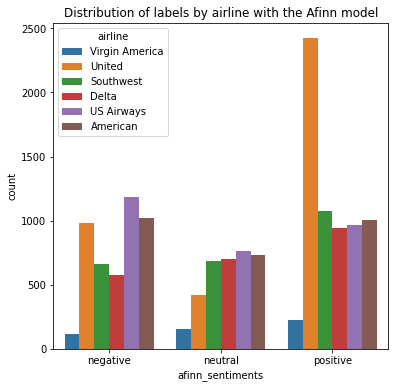

In [ ]:
fig = plt.figure(figsize=(6, 6))
sns.countplot( x = 'afinn_sentiments', data = df_af, hue = 'airline', order = label_order)
plt.title('Distribution of labels by airline with the Afinn model')
fig.savefig('afinn_labels_airline.png')

files.download('afinn_labels_airline.png')

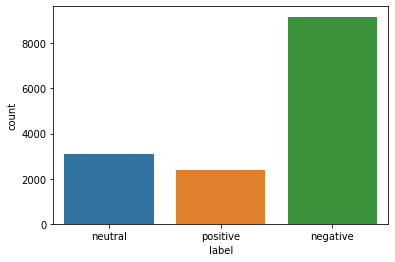

In [ ]:
sns.countplot( x = 'label', data = df_af)

In [ ]:
#Confusion matrix
df_afinn = pd.DataFrame(pd.crosstab(df_af.label, df_af.afinn_sentiments, normalize = 'index'))
print(df_afinn.to_latex()) 

\begin{tabular}{lrrr}
\toprule
afinn\_sentiments &  negative &   neutral &  positive \\
label    &           &           &           \\
\midrule
negative &  0.444541 &  0.220092 &  0.335367 \\
neutral  &  0.122298 &  0.389480 &  0.488222 \\
positive &  0.035971 &  0.097334 &  0.866695 \\
\bottomrule
\end{tabular}



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_af.label, df_af.afinn_sentiments))

              precision    recall  f1-score   support

    negative       0.90      0.44      0.59      9178
     neutral       0.35      0.39      0.37      3099
    positive       0.31      0.87      0.46      2363

    accuracy                           0.50     14640
   macro avg       0.52      0.57      0.47     14640
weighted avg       0.69      0.50      0.52     14640



**Interpretation of the results:**

Overall, the afinn sentiment has a completely different distribution from the initial labels. Thus, the afinn model seem to perform poorly on our dataset. 

The table above can be interpreted as a confusion matrix on the entire dataset. One can see that the afinn model performs relatively well when predicting positive tweets on the airline companies. However, the performance for the negative and neutral tweets is not so good, especially since the algorithm seem to predict more often neutral labels as good. 

Very likely this model is too simplistic as it only assigns a negative score when it sees a negative word. An important limit from the model is that it does not detect negations, irony or sarcasm. Indeed, it adapts poorly to the context of the tweet. This explains why the performance are limited on our dataset. As this model is very naive, it will be used as a baseline for assessing the results of other models. Consequently, I will try to see if using more complex approaches allows us to improve the accuracy of our model.

# BERT MODEL


In [10]:
! pip install transformers

     |████████████████████████████████| 4.0 MB 5.6 MB/s 
     |████████████████████████████████| 895 kB 32.2 MB/s 
     |████████████████████████████████| 6.6 MB 33.2 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split


In [13]:
# Read data, map with numbers the label and split.
data = pd.read_csv("Tweets.csv")
map = {'negative': 0, 'neutral':1, 'positive':2}
unique = np.unique(data['airline_sentiment'])
map = {textual_value:index for index,textual_value in enumerate(map)}
data['airline_sentiment'] = data['airline_sentiment'].map(map)
np.random.seed(112)
data, test = train_test_split(data, test_size=0.2)

In [14]:
# Define pretrained tokenizer and model using Distilbert
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [15]:
# ----- 1. Preprocess data -----#
# Preprocess data
X = list(data["text"])
y = list(data["airline_sentiment"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [16]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [17]:
# This step could take some time with "normal execution" (around 1h).
# Please Use execution with GPU or others methods to make it faster (around 2 min). 
# Of course we could incrase numbers of Epoch
# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    seed=0,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9369
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 293


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=293, training_loss=0.531246614944406, metrics={'train_runtime': 144.9345, 'train_samples_per_second': 64.643, 'train_steps_per_second': 2.022, 'total_flos': 162410773045446.0, 'train_loss': 0.531246614944406, 'epoch': 1.0})

In [18]:
# ----- 3. Predict -----#
# Load test data
test_data = test
X_test = list(test_data["text"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
trues = test_data.airline_sentiment.values

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 2928
  Batch size = 8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

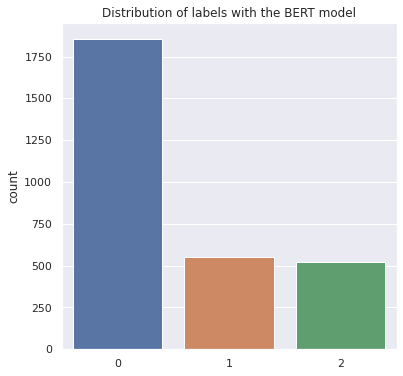

In [49]:
label_order = [0, 1, 2]
fig = plt.figure(figsize=(6, 6))
sns.countplot(x = y_pred, order = label_order)
plt.title('Distribution of labels with the BERT model')
fig.savefig('BERT_labels.png')

files.download('BERT_labels.png')

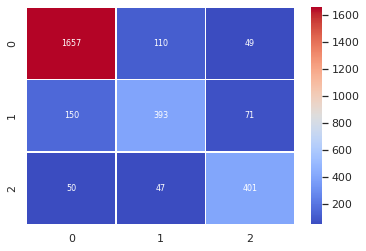

In [47]:
#1st confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
%matplotlib inline

cm = confusion_matrix(np.array(trues).flatten(), np.array(y_pred).flatten())
df_cm = pd.DataFrame(cm)
#config plot sizes
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()


In [42]:
# Confusion matrix for Latex
print('Matrice de confusion:')
cm_BERT = confusion_matrix(np.array(trues).flatten(), np.array(y_pred).flatten(),normalize="true")
df_BERT = df_cm = pd.DataFrame(cm_BERT)
print(df_BERT.to_latex())


Matrice de confusion:
\begin{tabular}{lrrr}
\toprule
{} &         0 &         1 &         2 \\
\midrule
0 &  0.912445 &  0.060573 &  0.026982 \\
1 &  0.244300 &  0.640065 &  0.115635 \\
2 &  0.100402 &  0.094378 &  0.805221 \\
\bottomrule
\end{tabular}



In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
print(classification_report(np.array(trues).flatten(), np.array(y_pred).flatten()))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1816
           1       0.71      0.64      0.68       614
           2       0.77      0.81      0.79       498

    accuracy                           0.84      2928
   macro avg       0.79      0.79      0.79      2928
weighted avg       0.83      0.84      0.84      2928



#TF-IDF model 

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.33, random_state=42)
X, y = resample(X_train, y_train, random_state=42)

vectorizer = TfidfVectorizer()
X_res = vectorizer.fit_transform(X)
X_test2 = vectorizer.transform(X_test)

In [ ]:
lr = LogisticRegression()
lr.fit(X_res, y.array)
y_pred = lr.predict(X_test2)
proba_pred = lr.predict_proba(X_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

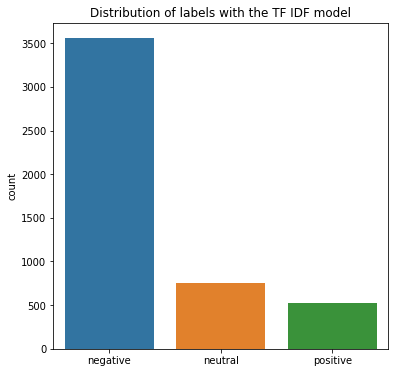

In [ ]:
fig = plt.figure(figsize=(6, 6))
sns.countplot(x = y_pred, order = label_order)
plt.title('Distribution of labels with the TF IDF model')
fig.savefig('tf_idf_labels.png')

files.download('tf_idf_labels.png')

In [ ]:
print('Matrice de confusion:')
df_tfidf = pd.DataFrame(pd.crosstab(y_test, y_pred, normalize = 'index'))
print(df_tfidf.to_latex())

Matrice de confusion:
\begin{tabular}{lrrr}
\toprule
col\_0 &  negative &   neutral &  positive \\
airline\_sentiment &           &           &           \\
\midrule
negative          &  0.937439 &  0.048622 &  0.013938 \\
neutral           &  0.446138 &  0.496951 &  0.056911 \\
positive          &  0.297510 &  0.149410 &  0.553080 \\
\bottomrule
\end{tabular}



In [ ]:
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

    negative       0.83      0.94      0.88      3085
     neutral       0.68      0.52      0.59       984
    positive       0.83      0.60      0.70       763

    accuracy                           0.80      4832
   macro avg       0.78      0.69      0.72      4832
weighted avg       0.80      0.80      0.79      4832



Overall, the TF IDF model seems to drastically improve accuracy for classifying negative tweets compared to the Lexicon models. While the accuracy is increased for the neutral labels, it is reduced for positive labels. However, this is mainly due to the fact that most of the tweets were classified as positive according to the Lexison model. Thus, TF-IDF seem to perform better than the AFINN model on our dataset, as suggested by the confusion matrix.

Although the TF-IDF model is more complex than the Lexicon method, it still has some major limitations that could be overcome with more complex framework. One of the main limitation is that the model is highly dependent from the corpus it is trained on. If there are some tweets in the test set using a vocabulary that the model has not used before, it will not be able to take it into account when classifying it. 

# Hybrid approach : Combining Lexicon to TF-IDF 

Recent literature has explored hybrid approaches to combine lexicon apporaches to existing machine learning models.
Bashar (2022) underlines that, while Lexicon have a good performance for classifying text data, they tend to perform poorly on unstructured data such as tweets. Thus, they propose a hybrid apporach to overcome this issue. Similarly, Muhammad et al.(2014) highlights that Lexicon models are crucial for opinion mining but adapt poorly to the context. Thus, they aim at developping a framework of hybrid lexicon with weights and show that it increases the accuracy for lexicon models.
Other work has tried to investigate hybrid approaches with Bayes Classifier.


This project: 
I will try to create a hybrid approach to overcome the static lexison issue to improve accuracy on tweets sentiment analysis inthe caseof airline sentiment.
To create a hybrid model, we will compute a logistic regression on the Afinn score in order to obtain a probability distribution that can be combined with the probability distribution of the TD IDF model.

List of references : 


- A. Muhammad, N. Wiratunga and R. Lothian, "A Hybrid Sentiment Lexicon for Social Media Mining," 2014 IEEE 26th International Conference on Tools with Artificial Intelligence, 2014, pp. 461-468, doi: 10.1109/ICTAI.2014.76.

- Bashar, M.K. A Hybrid Approach to Explore Public Sentiments on COVID-19. SN COMPUT. SCI. 3, 220 (2022). https://doi.org/10.1007/s42979-022-01112-1

In [ ]:
#Including TF-IDF results in dataframes
df_res = pd.DataFrame({
    'X_test' : X_test.tolist(),
    'y_test': y_test.tolist(),
    'y_pred': y_pred.tolist()
})
df_train = pd.DataFrame({
     'X_train' : X,
    'y_train': y})

In [ ]:
print(proba_pred)

[[0.20308865 0.05910121 0.73781013]
 [0.92785314 0.06239327 0.0097536 ]
 [0.94293749 0.04381241 0.0132501 ]
 ...
 [0.92731653 0.04281724 0.02986623]
 [0.1943191  0.73209843 0.07358247]
 [0.64162158 0.28221385 0.07616457]]


In [ ]:
df_train

,X_train,y_train
13134,"@AmericanAir My pleasure, next AA flight - thi...",positive
2165,@united Not until tomorrow night. And the hote...,negative
12749,@AmericanAir anything in particular I should a...,neutral
8475,@JetBlue works with Google #chrome but not Int...,neutral
7122,:( RT @JetBlue: Our fleet's on fleek. http://t...,negative
...,...,...
2336,@united Why was I forced to check my rollaboar...,negative
1898,@united you should spend all of the money you ...,negative
11367,@USAirways I paid for my ticket on @PayPal on ...,negative
11138,@USAirways yes travel is complete flight 5095 ...,neutral


In [ ]:
#Computing the Afinn scores for the training set

scores = [afn.score(article) for article in df_train['X_train']]
sentiment = ['positive' if score > 0
                          else 'negative' if score < 0
                              else 'neutral'
                                  for score in scores]
     
# dataframe creation
df_train['afinn_scores'] = scores
df_train['afinn_sentiments'] = sentiment
print(df_train)

                                                 X_train   y_train  \
13134  @AmericanAir My pleasure, next AA flight - thi...  positive   
2165   @united Not until tomorrow night. And the hote...  negative   
12749  @AmericanAir anything in particular I should a...   neutral   
8475   @JetBlue works with Google #chrome but not Int...   neutral   
7122   :( RT @JetBlue: Our fleet's on fleek. http://t...  negative   
...                                                  ...       ...   
2336   @united Why was I forced to check my rollaboar...  negative   
1898   @united you should spend all of the money you ...  negative   
11367  @USAirways I paid for my ticket on @PayPal on ...  negative   
11138  @USAirways yes travel is complete flight 5095 ...   neutral   
9653   @USAirways I can legitimately say that I would...  negative   

       afinn_scores afinn_sentiments  
13134           5.0         positive  
2165            2.0         positive  
12749           1.0         positive  
847

In [ ]:
#Computing a logistic regression on the dataset to obtain a probability distribution for the afinn score:
lr = LogisticRegression()
sc = df_train['afinn_scores'].values.reshape(-1, 1)
lr.fit(sc, y.array)

LogisticRegression()

In [ ]:
#Then, we recompute the scores for the test set and then we compute the probability distribution of each class on the test set using the probability distribution of the score for the Afinn dataset:
scores = [afn.score(article) for article in df_res['X_test']]
sentiment = ['positive' if score > 0
                          else 'negative' if score < 0
                              else 'neutral'
                                  for score in scores]

df_res['afinn_scores'] = scores

In [ ]:
sc2 = df_res['afinn_scores'].values.reshape(-1, 1)
df_res['afinn_sentiment'] = lr.predict(sc2)
afinn_proba= lr.predict_proba(sc2)

In [ ]:
#Computing an example of model where we would take the average of each model
final_scores = np.argmax( 0.5 *proba_pred + 0.5 * afinn_proba, axis=-1)-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

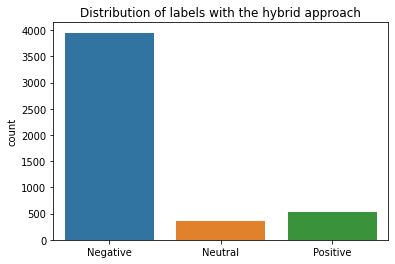

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x = final_scores)
plt.title('Distribution of labels with the hybrid approach')
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
fig.savefig('hybrid_labels.png')

files.download('hybrid_labels.png')

In [ ]:
print('Matrice de confusion:')
df_hybrid= pd.DataFrame(pd.crosstab(df_res['y_test'], final_scores, normalize = 'index'))
print(df_hybrid.to_latex())

Matrice de confusion:
\begin{tabular}{lrrr}
\toprule
col\_0 &        -1 &         0 &         1 \\
y\_test   &           &           &           \\
\midrule
negative &  0.974068 &  0.011994 &  0.013938 \\
neutral  &  0.699187 &  0.252033 &  0.048780 \\
positive &  0.340760 &  0.086501 &  0.572739 \\
\bottomrule
\end{tabular}



In [ ]:
y_test = y_test.replace(to_replace = ['negative', 'neutral', 'positive'], value = [-1,0, 1])

In [ ]:
from sklearn.metrics import accuracy_score
#Combine the scores from the AFINN model with TF IDF with weights

for w in np.arange(0.1, 1, step = 0.1):
  y_pred = np.argmax( w *proba_pred + (1-w) * afinn_proba, axis=-1)-1

  print('Weight:', w, 'Accuracy:', accuracy_score(y_test, y_pred))


Weight: 0.1 Accuracy: 0.675703642384106
Weight: 0.2 Accuracy: 0.6877069536423841
Weight: 0.30000000000000004 Accuracy: 0.7133692052980133
Weight: 0.4 Accuracy: 0.7386175496688742
Weight: 0.5 Accuracy: 0.7636589403973509
Weight: 0.6 Accuracy: 0.7781456953642384
Weight: 0.7000000000000001 Accuracy: 0.7870447019867549
Weight: 0.8 Accuracy: 0.7895281456953642
Weight: 0.9 Accuracy: 0.7909768211920529


Overall the accuracy improves when increasing the weight towards a TF-IDF model and the Lexison model seem to underperform. Thus, building a hybrid model does not seem to improve accuracy of the model.